In [1]:
import matplotlib.pyplot as plt
import psycopg2
import time

In [2]:
# Параметры подключения к базам данных
MASTER_DB = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5433'
}

STANDBY_DB = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5434'
}

In [3]:
# Логгер записей
class RecordLogger:
    def __init__(self):
        self.timestamps = []
        self.master_counts = []
        self.standby_counts = []

    def _get_record_count(self, db_config):
        """Получает количество записей из таблицы 'data_table'."""
        try:
            with psycopg2.connect(**db_config) as conn:
                with conn.cursor() as cur:
                    cur.execute("SELECT COUNT(*) FROM data_table")
                    return cur.fetchone()[0]
        except Exception as e:
            print(f"Ошибка при получении количества записей: {e}")
            return -1

    def log(self):
        """Логирует текущее время и количество записей в primary и standby БД."""
        current_time = time.time()
        self.timestamps.append(current_time)
        self.master_counts.append(self._get_record_count(MASTER_DB))
        self.standby_counts.append(self._get_record_count(STANDBY_DB))

    def plot(self):
        """Строит график изменения количества записей во времени."""
        if not self.timestamps:
            print("Нет данных для отображения.")
            return

        elapsed_time = [t - self.timestamps[0] for t in self.timestamps]

        print(f'Максимум записей в primary: {max(self.master_counts)} / {len(elapsed_time)} точек')
        print(f'Максимум записей в standby: {max(self.standby_counts)} / {len(elapsed_time)} точек')

        plt.figure(figsize=(10, 5))
        plt.plot(elapsed_time, self.master_counts, label='Master', marker='o')
        plt.plot(elapsed_time, self.standby_counts, label='Standby', linestyle='--')
        plt.title("Количество записей в БД во времени")
        plt.xlabel("Время (секунды с начала логирования)")
        plt.ylabel("Количество записей")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [4]:
class ReverseProxy:
    """Реверс-прокси для переключения между основной и резервной БД."""

    def __init__(self):
        self.master_active = True
        self.master_counts = []
        self.standby_counts = []

    def promote_standby(self, db_config):
        """Продвигает standby БД в состояние master."""
        try:
            with psycopg2.connect(**db_config) as conn:
                with conn.cursor() as cur:
                    cur.execute("SELECT pg_promote()")
                    conn.commit()
            print("Standby DB успешно продвинута в primary.")
        except Exception as e:
            print(f"Ошибка при выполнении promote: {e}")

    def _insert_raw(self, db_config, value):
        """Выполняет вставку данных напрямую в указанную БД."""
        try:
            with psycopg2.connect(**db_config) as conn:
                with conn.cursor() as cur:
                    cur.execute("INSERT INTO data_table (name) VALUES (%s)", (value,))
                    conn.commit()
            return True
        except Exception as e:
            print(f"Ошибка при вставке в БД: {e}")
            return False

    def insert(self, value):
        """
        Вставляет данные в активную БД.
        Если primary недоступна, переключается на standby и выполняет promote.
        """
        if self.master_active:
            success = self._insert_raw(MASTER_DB, value)
            if not success:
                print("Primary DB недоступна. Переключаемся на Standby.")
                self.master_active = False
                self.promote_standby(STANDBY_DB)

        if not self.master_active:
            self._insert_raw(STANDBY_DB, value)


In [5]:
# Получение данных которые наобходимо записать в БД
def get_value() -> str:
    return "test string"

# Создать таблицу с тестовыми данными
def init_table(db_config):
    try:
        with psycopg2.connect(**db_config) as conn:
            with conn.cursor() as cur:
                cur.execute("CREATE TABLE data_table (id SERIAL, name TEXT);")
    except Exception as e:
        with psycopg2.connect(**db_config) as conn:
            with conn.cursor() as cur:
                cur.execute("DELETE FROM data_table;")

Ошибка при получении количества записей: connection to server at "localhost" (127.0.0.1), port 5433 failed: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

Ошибка при вставке в БД: connection to server at "localhost" (127.0.0.1), port 5433 failed: FATAL:  the database system is shutting down

Primary DB недоступна. Переключаемся на Standby.
Standby DB успешно продвинута в primary.
Ошибка при получении количества записей: connection to server at "localhost" (127.0.0.1), port 5433 failed: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

Ошибка при получении количества записей: connection to server at "localhost" (127.0.0.1), port 5433 failed: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

Ошибка при получении количества за

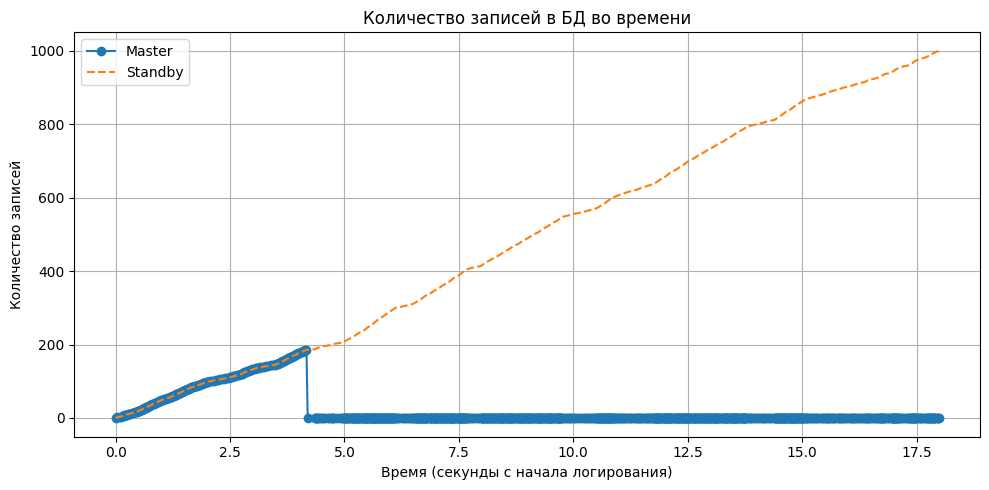

In [8]:
proxy = ReverseProxy()
logger = RecordLogger()
init_table(MASTER_DB)

for _ in range(1000):
    proxy.insert(get_value())
    logger.log()
    
logger.plot()